# FINAL PROJECT

In this Problem, we build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. We have a dataset of 10,000 tweets that were hand labeled.This is an NLP problem and we will be using various methods to determine the accuracy with which we can predict this.

# Loading Packages

In [2]:
import pandas as pd
import numpy as np
import re 
import time 
import unidecode 
import nltk
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from autocorrect import Speller 
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords 
from nltk import word_tokenize 
import string 
import joblib
import logging
import gensim.downloader
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from scipy.sparse import hstack
from gensim.models import Word2Vec, word2vec
plt.rcParams["figure.figsize"] = (12, 6)

# Loading datasets

In [3]:
# glove_vectors = gensim.downloader.load('glove-twitter-100')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [4]:
stop=set(stopwords.words('english'))

In [5]:
df_train = pd.read_csv('train.csv')

Each sample in the data has the following information:

- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

In [9]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [12]:
print("The shape of train data:",df_train.shape)

The shape of train data: (7613, 5)


# DATA ANALYSIS

- For this problem we will be seeing things such as distribution avg length of text.
- The distribution of words in the data.
- Distribution of avg length of a word in the sentence.
- We will count stopwords in the data.
- We will count the words except the stopwords in the data.
- We will plot the bigrams and trigrams in the data.

In [15]:
df_train['text'] = df_train['text'].apply(lambda x: x.lower())

Text(0.5, 1.0, 'Data text length dist')

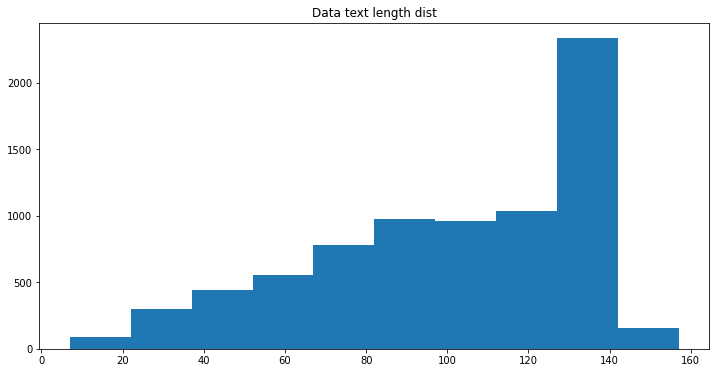

In [16]:
plt.hist(df_train['text'].str.len())
plt.title("Data text length dist")

Text(0.5, 1.0, 'No of words in each sentence for data')

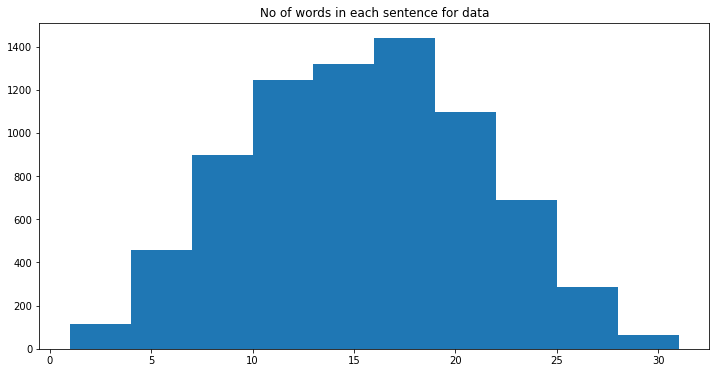

In [18]:
#Number of words in each sentence
plt.hist(df_train['text'].str.split().map(lambda x: len(x)))
plt.title("No of words in each sentence for data")

Text(0.5, 1.0, 'Avg word length in each sentence for data')

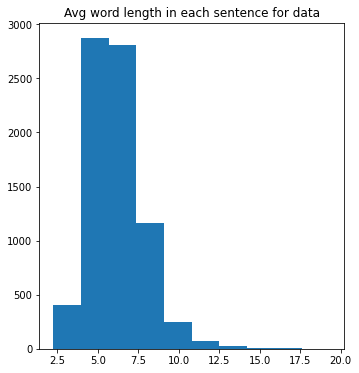

In [19]:
#Avg word length
plt.subplot(1, 2, 1)
plt.hist(df_train['text'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)))
plt.title("Avg word length in each sentence for data")

In [21]:
#Helper function to plot the count of stopwords
def plot_stopwords(text):
    stop=set(stopwords.words('english'))
    corpus = []
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    del corpus
    plt.bar(x,y)

Stopwords are words like "the,a,are,an,to" etc these words actually are not that useful in providing context to the machine learning models and may cause problems , but with deep learning models as we will see down below they work really well.

Text(0.5, 1.0, 'Stopwords count in data')

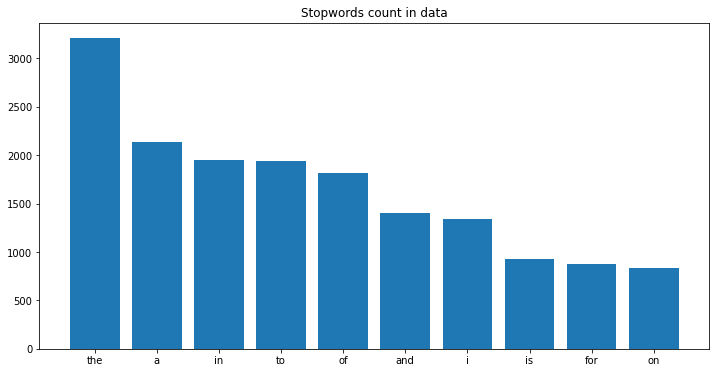

In [24]:
plot_stopwords(df_train['text'])
plt.title("Stopwords count in data")

In [27]:
#No stop words here
def plot_top_words(text):
    stop=set(stopwords.words('english'))
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    corpus = [word for word in corpus if word not in stop]
    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y,y=x)

As we can see that words like evacuation and orders are really prevalant in the dataset , that means they will have a really high weight while prediction. These words are usually used when the natural disaster is happening.

Text(0.5, 1.0, 'Top Non Stop words in data')

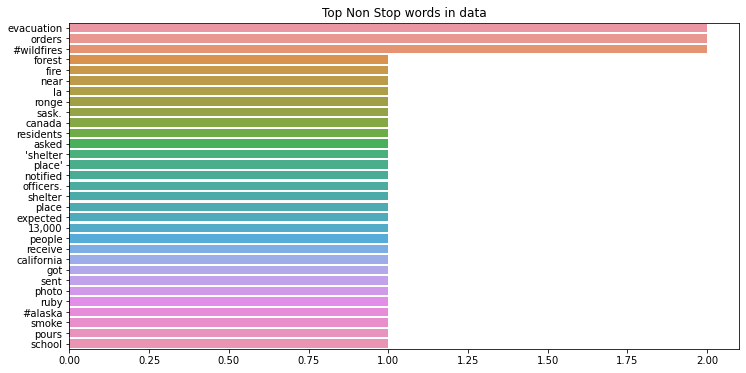

In [30]:
plot_top_words(df_train['text'][1:5])
plt.title("Top Non Stop words in data")

Lets talk about bigrams here, bigrams are basically 2  words occuring at the same time. This information helps the models a lot , how? model can understand the context by evaluating how two words occur side by side and using that it can distinguish between a person tweeting right details about a natural disaster and a person tweeting wrong details about it. It basically captures this essence.

In [32]:
def plot_top_ngrams(text, n=2):
    stop=set(stopwords.words('english'))
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    corpus =[word for word in corpus if word not in stop]
    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(corpus,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    
    sns.barplot(x=y,y=x)

This graph looks weird, maybe we need to clean data since http means there are links in it?

Text(0.5, 1.0, 'Top bigrams in data')

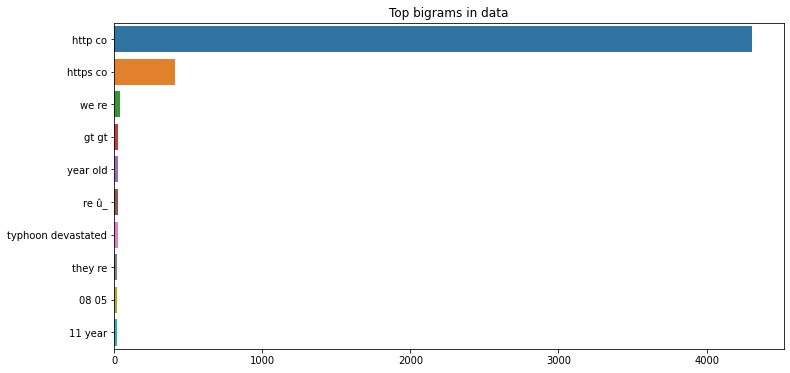

In [34]:
plot_top_ngrams(df_train['text'])
plt.title("Top bigrams in data")

Trigrams are nothing but 3 words that are occuring together, the graph below is better but still needs cleaning.

Text(0.5, 1.0, 'Top trigrams in Train')

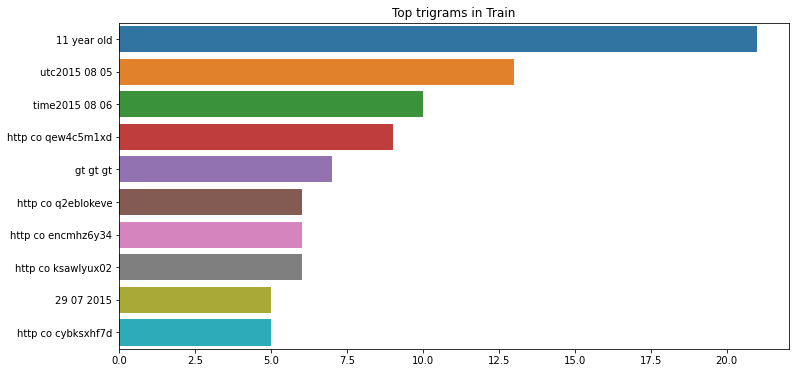

In [36]:
plot_top_ngrams(df_train['text'],3)
plt.title("Top trigrams in Train")


Here I am loading some pre trained vectors and some files.

- cont_map will be used in preprocessing.
- trainDatavecs is what i used to create word embeddings.
- w_tokenizer is used in preprocessing.
- lemmatizer is used in preprocessing.
- Spell is used to call a function which checks for spell errors in the text but i don't use it, because some of the spell checks are bad.

In [38]:
cont_map = joblib.load("contraction_map.pkl")
trainDataVecs = joblib.load('glove100_stats_text.pkl')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()  
# spell = Speller(lang='en')

The text preprocessing this is really important for machine learning model, the preprocessing I m doing is.

- Removing extra \\n,\t in text, this occur in data scraping stage.
- Using beautiful soup to parse the html tags such as http://www.google.com .
- We then remove the http and .com stuff.
- We then remove extra whitespaces.
- Removing unicode characters, now these happen when the data is scraped and emoji's are not resolved in text format , if you don't encode the text while scraping and saving using ("utf-8") encoding we see this we need to remove these.
- Then we change the words like cherrrrrry to cherry.
- Then using the cont_map which is basically a dictionary which has mapping of words like can't: can not, and we use that in our text.
- The we remove special characters like #, and numbers from the data.
- The we use lemmatizer to , change words like swimming to swim.
- And we remove stopwords.

In [39]:
def text_preprocessing(text,cont_map):
    # Replacing all the occurrences of \n,\\n,\t,\\ with a space.
    text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('. com', '.com')
    #strip html tags
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    #remove links
    stripped_text = re.sub(r'http\S+', '', stripped_text)
    stripped_text = re.sub(r"\ [A-Za-z]*\.com", " ", stripped_text)
    #remove whitespace
    pattern = re.compile(r'\s+') 
    no_whitespace = re.sub(pattern, ' ', stripped_text)
    stripped_text = no_whitespace.replace('?', ' ? ').replace(')', ') ')
    #Removing unicode characters
    stripped_text = unidecode.unidecode(stripped_text)
    #Changing words like cherrrrrrrry to cherry
    pattern_alpha= re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    stripped_text = pattern_alpha.sub(r"\1\1", stripped_text) 
    pattern_punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    stripped_text = pattern_punct.sub(r'\1', stripped_text)
    stripped_text = re.sub(' {2,}',' ', stripped_text)
    
    tokens = stripped_text.split(' ')
    for word in tokens: 
         if word in cont_map: 
                tokens = [item.replace(word, cont_map[word]) for item in tokens]
                
    text = ' '.join(str(e) for e in tokens) 
    #removing special characters and numbers
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = re.sub(r"[^a-zA-Z:$-,%.?!]+", ' ', text)
    #lemmatization swimming , swim
    text = [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)]
    #removing stopwords
    text = ' '.join([word for word in text if word not in stop])
    # text = spell(text)
    return text


# Cleaning data

In [40]:
cleaned_text = []
for i in tqdm(df_train['text']):
    cleaned_text.append(text_preprocessing(i,cont_map))
df_train['text'] = cleaned_text

100%|██████████| 7613/7613 [00:03<00:00, 2268.27it/s]


This data is now presented in the wordcloud which basically tells us the top words used in the corpus.

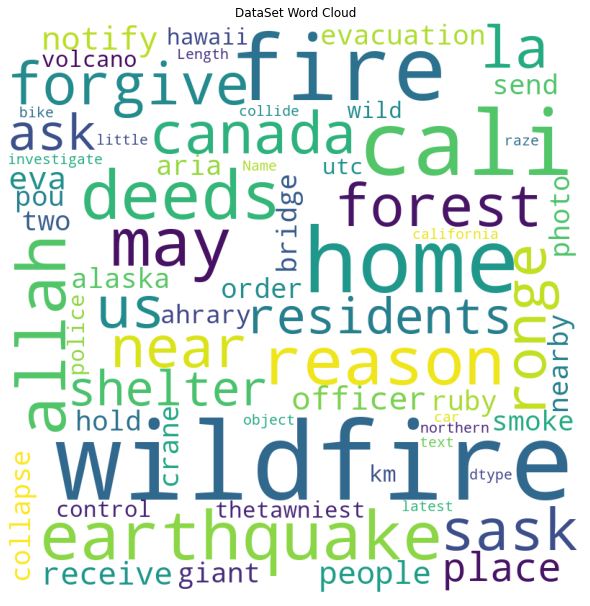

In [42]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white').generate(str(df_train['text']))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("DataSet Word Cloud")
plt.show()

Here we check distribution of target variables seems evenly distributed so we can use accuracy as our metric.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


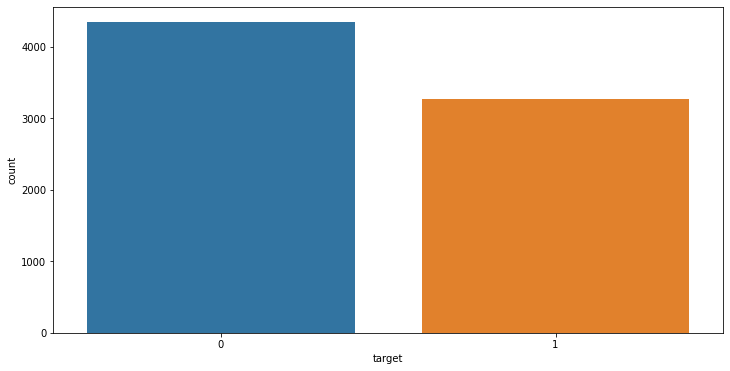

In [43]:
sns.countplot(df_train['target'])

In [44]:
df_train.nunique()

id          7613
keyword      221
location    3341
text        6857
target         2
dtype: int64

Splitting the data to test and train and also we are stratifying it so that test and train have the same distribution.


In [46]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['target'],axis=1),df_train['target'], test_size=0.2,stratify=df_train['target'], random_state=42)

So for models we train a machine learning model random forest and use various methods for feature enginnering our text data. Since machine learning needs numbers to evaluate we need some way to create meaningful features out of text data, the methods we are using to train with machine learning models are

- Countvectorizer
  - Character level.
  - Word level.
  - Character level + Word level. 

- TFIDF
- Word2Vec




## Countvectorizer

- It creates a document term matrix, which is a set of dummy variables that indicates if a particular word appears in the document.

-  Count vectorizer will fit and learn the word vocabulary and try to create a document term matrix in which the individual cells denote the frequency of that word in a particular document, which is also known as term frequency, and the columns are dedicated to each word in the corpus.

- Below were are creating a word level count matrix, and also removing stopwords.

In [47]:
word_vectorizer = CountVectorizer(stop_words = 'english',analyzer='word')
word_vectorizer.fit(df_train['text'])
train_word_features = word_vectorizer.transform(X_train['text'])
test_word_features = word_vectorizer.transform(X_test['text'])

In [48]:
clf = RandomForestClassifier(random_state=22)
clf.fit(train_word_features,y_train)
print("Accuracy score on the test set for word level;:",accuracy_score(y_true=y_test,y_pred=clf.predict(test_word_features)))

Accuracy score on the test set for word level;: 0.7866053841103086


- Here we are doing character level count matrix, i.e creating a,b,c,d and its occurences in the corupus for each text, i.e a row.

In [49]:
char_vectorizer = CountVectorizer(stop_words = 'english',analyzer='char')
char_vectorizer.fit(df_train['text'])
train_char_features = char_vectorizer.transform(X_train['text'])
test_char_features = char_vectorizer.transform(X_test['text'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  "The parameter 'stop_words' will not be used"


In [50]:
clf = RandomForestClassifier(random_state=22)
clf.fit(train_char_features,y_train)
print("Accuracy score on the test set for char level;:",accuracy_score(y_true=y_test,y_pred=clf.predict(test_char_features)))

Accuracy score on the test set for char level;: 0.6894287590282338


- We are combining the word + char level features and trying to train a model.

In [51]:
train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

In [52]:
clf = RandomForestClassifier(random_state=22)
clf.fit(train_features,y_train)
print("Accuracy score on the test set for both combined:",accuracy_score(y_true=y_test,y_pred=clf.predict(test_features)))

Accuracy score on the test set for both combined: 0.7669074195666448


## TFIDF

Term frequency-inverse document frequency ( TF-IDF) gives a measure that takes the importance of a word into consideration depending on how frequently it occurs in a document and a corpus.

- Term frequency (TF)
- Inverse document frequency (IDF)

### Term Frequency

Term frequency denotes the frequency of a word in a document. For a specified word, it is defined as the ratio of the number of times a word appears in a document to the total number of words in the document.

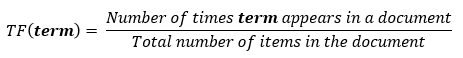


### Inverse Document Frequency (IDF)

It measures the importance of the word in the corpus. It measures how common a particular word is across all the documents in the corpus.

It is the logarithmic ratio of no. of total documents to no. of a document with a particular word.

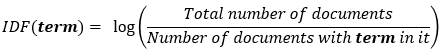


### TFIDF FORMULA

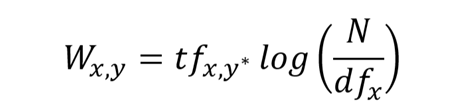


In [53]:
word_vectorizer = TfidfVectorizer(stop_words = 'english')
word_vectorizer.fit(df_train['text'])
train_word_features = word_vectorizer.transform(X_train['text'])
test_word_features = word_vectorizer.transform(X_test['text'])

In [54]:
clf = RandomForestClassifier(random_state=22)
clf.fit(train_word_features,y_train)
print("Accuracy score on the test set for tfidf:",accuracy_score(y_true=y_test,y_pred=clf.predict(test_word_features)))

Accuracy score on the test set for tfidf: 0.7918581746552856


# WORD2VEC 

Word2Vec creates vectors of the words that are distributed numerical representations of word features – these word features could comprise of words that represent the context of the individual words present in our vocabulary. Word embeddings eventually help in establishing the association of a word with another similar meaning word through the created vectors.

As seen in the image below where word embeddings are plotted, similar meaning words are closer in space, indicating their semantic similarity.

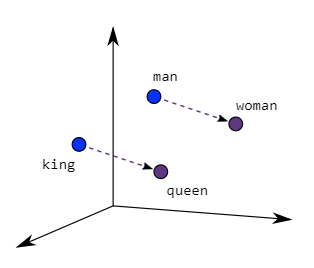

Since word2vec is model that converts words to embeddings of a given length, in our case we are using 100 embeddings since we don't have enough computation power. But we can use 300 embeddings. We will just use a pretrained Glove Model with 100 embedding trained on 100,000 of words.

But you might ask a question , if word2vec uses vectors of length 100 and converts only words to sentences then how will we use it ?

- We convert every word to a embedding of 100 in a sentence and average all of them in a sentence to give us a uniform embedding of size 100.
- We can also use models such as Doc2vec which give much richer embeddings for a sentence but we don't have enough cpu power since these models are not supported on gpus so we don't use it.
- Using word2vec might lose some information in a sentence.

The helper functions downbelow helps us create wordembeddings which then are provided to a randomforest model.

In [57]:
def review_to_wordlist(review, remove_stopwords=False):
    """
    Convert a review to a list of words. Removal of stop words is optional.
    """
    # remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    
    # convert to lower case and split at whitespace
    words = review_text.lower().split()
    
    # remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words

def review_to_sentences(review, tokenizer, remove_stopwords=False):
    """
    Split review into list of sentences where each sentence is a list of words.
    Removal of stop words is optional.
    """
    # use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())

    # each sentence is furthermore split into words
    sentences = []    
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
            
    return sentences


In [58]:
def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0.
    index2word_set = set(model.index2word)  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec,model[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec

def get_avg_feature_vecs(reviews, model, num_features):
    """
    Calculate average feature vectors for all reviews
    """
    counter = 0
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')  # pre-initialize (for speed)
    
    for review in tqdm(reviews):
        review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
        counter = counter + 1
    return review_feature_vecs

Creating wordembeddings here and saving it for quick use since this takes 30 mins to finish.

In [59]:
# clean_train_reviews = []
# for review in tqdm(df_train['text']):
#     clean_train_reviews.append(review_to_wordlist(review, remove_stopwords=True))
# trainDataVecs = get_avg_feature_vecs(clean_train_reviews, glove_vectors, num_features=100)
# joblib.dump(trainDataVecs, 'glove100_stats_text.pkl')

In [60]:
df_vecs = pd.DataFrame(trainDataVecs,columns = ['name_'+str(x) for x in range(len(trainDataVecs[0]))])
df_vecs['target'] = df_train['target']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df_vecs.drop(['target'],axis=1),df_vecs['target'], test_size=0.2,stratify=df_vecs['target'], random_state=42)

In [62]:
clf = RandomForestClassifier(random_state=22)
clf.fit(X_train,y_train)
print("Accuracy score on the test set for char level;:",accuracy_score(y_true=y_test,y_pred=clf.predict(X_test)))

Accuracy score on the test set for char level;: 0.8122127380170716


# Deep Learning

- Here we use a package called simple transformers which helps us to leverage transformer models to classify nlp tasks.
- The transformer model we will be using is called Roberta.

## Transformer model

During pretraining, Roberta uses two objectives: masked language modeling and full sentence prediction.

Masked Language Modeling(MLM) basically masks 80% of the 15% of the randomly selected input tokens and uses the other tokens to attempt to predict the mask (missing word).

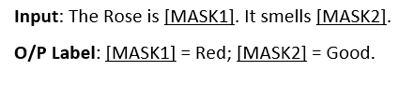

Next Sentence Prediction(NSP)is a binary classification loss for predicting whether two segments follow each other or are from a different document to create a semantic meaning.

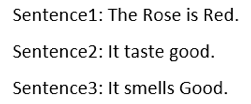

Why not Bert you might ask?

Roberta uses -:

- 160GB of training data, which is more.
- Uses dynamic masking pattern instead of static masking pattern.
- Replacing the next sentence prediction objective with full sentences without NSP.
- Training on Longer Sequences.

Now we train the models, there will be two models

- Model 1 will be trained with cleaned data , by removing stopwords.
- Model 2 will be trained with data in which we just remove whitespaces and numbers in the data.

Why two models?

This to show that pretrained transformers understand context much better with stop words than the normal machine learning models. Since these models where trained on real world data without much preprocessing so they can also understand the text better like real humans can.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['target'],axis=1),df_train['target'], test_size=0.2,stratify=df_train['target'], random_state=42)

In [66]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)


In [67]:
model_args = ClassificationArgs(num_train_epochs=2,overwrite_output_dir=True)

In [68]:
model = ClassificationModel(
    "roberta", "roberta-base",num_labels=2, args=model_args
)

X_train['labels'] = y_train
X_test['labels'] = y_test
# Train the model
model.train_model(X_train[["text","labels"]])

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(X_test[["text","labels"]])

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/6090 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/762 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/762 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1523 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2


Running Evaluation:   0%|          | 0/191 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.6383842725150729, 'tp': 509, 'tn': 745, 'fp': 124, 'fn': 145, 'auroc': 0.8826782515668825, 'auprc': 0.8669336992180481, 'eval_loss': 0.4453747002554189}


In [69]:
from scipy.special import softmax
probabilities = softmax(model_outputs, axis=1)

In [70]:
def get_auc(x):
  if x[0] > 0.5:
    return 0
  else:
    return 1
y_preds = []
for i in probabilities:
  y_preds.append(get_auc(i))

In [71]:
print("Accuracy score on the test set for cleaned data",accuracy_score(y_true=y_test,y_pred=y_preds))

Accuracy score on the test set for cleaned data 0.8233749179251477


In [72]:
df_train = pd.read_csv('train.csv')

def preprocess(x):  
  text = x.lower()
  text = re.sub('[^A-Za-z0-9]+', ' ', x)
  text = re.sub(r"[^a-zA-Z:$-,%.?!]+", ' ', x)

  return text

In [73]:
cleaned_text = []
for i in tqdm(df_train['text']):
    cleaned_text.append(preprocess(i))
df_train['text'] = cleaned_text

100%|██████████| 7613/7613 [00:00<00:00, 77135.30it/s]


In [74]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['target'],axis=1),df_train['target'], test_size=0.2,stratify=df_train['target'], random_state=42)

In [75]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)


In [76]:
model_args = ClassificationArgs(num_train_epochs=2,overwrite_output_dir=True)

In [77]:
model = ClassificationModel(
    "roberta", "roberta-base",num_labels=2, args=model_args
)

X_train['labels'] = y_train
X_test['labels'] = y_test
# Train the model
model.train_model(X_train[["text","labels"]])

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(X_test[["text","labels"]])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

  0%|          | 0/6090 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/762 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/762 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1523 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2


Running Evaluation:   0%|          | 0/191 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.6758954649762684, 'tp': 497, 'tn': 785, 'fp': 84, 'fn': 157, 'auroc': 0.9005438779855224, 'auprc': 0.9046599643793716, 'eval_loss': 0.4191099154075403}


In [78]:
probabilities = softmax(model_outputs, axis=1)
y_preds = []
for i in probabilities:
  y_preds.append(get_auc(i))


In [79]:
print("Accuracy score on the test set with uncleaned data",accuracy_score(y_true=y_test,y_pred=y_preds))

Accuracy score on the test set with uncleaned data 0.8417596848325674


# Accuracy Chart

 - CountVectorizer Word Model          : 78.66%
 - CountVectorizer Char Model          : 68.94%
 - CountVectorizer Word+Char Model     : 76.69%
 - Tfidf Model                         : 79.18%
 - Word2vec Model                      : 81.22%
 - Transformer Model with Cleaned data : 82.33%
 - Transformer Model with no cleaning  : 84.17%

# Improvements

- The countvectorizer, word2vec and tfidf models can be improved by adding more features such as location , avg len of sentence, avg word length in a sentence, avg char length of sentence, keyword, length of a sentence.
- Using better models such as Xgboost and use of cross validation , and model ensembling.

- The deep learning model on the other hand would be improved by providing more data, retraining the pretrained model but that won't be a good idea considering these models were also trained on twitter data.

- We could also ensemble different transformer models such as XLMBert, bert, distill bert and then use cross validation to increase the accuracy.

# Conclusion

- NLP is an amazing field with companies training such huge models such as bert with terabytes of data we don't need to make out own transformer models when we can directly use these pretrained ones to achieve state of the art accuracy.
- Methods such as countvectorizer, tfidf and word2vec are still really good methods of feature engineering for text data. They provide really good information about text in the data and really helpful for us to train models with high accuracy.
- If we have a tabular data with text some text information we can leverage tfidf, Countvectorizer and word2vec for feature engineering.